PostProcessing Lateral

In [592]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import medfilt
import ast

Import video

In [593]:
video_number = "2"
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = project_root / "data" / f"recording_{video_number}" / f"Recording_{video_number}.mp4" 
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}")

Opened: True, FPS: 59.94005994005994, Total Frames: 276.0


Import Lines

In [594]:
# Define the path to the CSV file
input_data_path = project_root / "data"/ "auxiliary_data" / "lane_lines" / f"three_lines_{video_number}.csv"

# Load the CSV file into a DataFrame
lines = pd.read_csv(input_data_path)


# convert string to list
for i in range(0, len(lines)):
    for j in range(0, 3):
        lines.iloc[i][j] = np.fromstring(lines.iloc[i][j].strip("[]"), sep=" ")
        lines.iloc[i][j] = lines.iloc[i][j].tolist()
        if lines.iloc[i][j][0] == 0 and lines.iloc[i][j][1] == 0 and lines.iloc[i][j][2] == 0 and lines.iloc[i][j][3] == 0:
            lines.iloc[i][j] = None


C:\Users\miche\AppData\Local\Temp\ipykernel_13532\4286604941.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lines.iloc[i][j] = np.fromstring(lines.iloc[i][j].strip("[]"), sep=" ")
C:\Users\miche\AppData\Local\Temp\ipykernel_13532\4286604941.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values

In [595]:
'''Disegna la linea sul frame'''
def write_line_on_frame(frame, line):
    # Create a copy of the original frame to draw the first line
    modified_frame = np.copy(frame)

    # Extract the first line's rho and theta
    if line is not None:
        x1, y1, x2, y2 = line
        
        # Draw the first line on the frame
        cv2.line(modified_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

    # return the modified frame
    return modified_frame

In [596]:
def write_lines_on_frame(frame, lines):
    for i in range(len(lines)):
        # print('linea', i, ':', lines[i])
        frame = write_line_on_frame(frame, lines[i])
    return frame

In [597]:
def divide_lines(lines):
    left_lines = []
    right_lines = []
    for i in range(len(lines)):
        if lines.iloc[i][1] is not None:
            x1_1 = lines.iloc[i][1][0]
            x2_1 = lines.iloc[i][1][2]
            if lines.iloc[i][2] is not None:
                x1_2 = lines.iloc[i][2][0]
                x2_2 = lines.iloc[i][2][2]
                min_x_1 = min(x1_1, x2_1)
                min_x_2 = min(x1_2, x2_2)
                if min_x_1 < min_x_2:
                    left_lines.append(lines.iloc[i][1])
                    right_lines.append(lines.iloc[i][2])
                else:
                    left_lines.append(lines.iloc[i][2])
                    right_lines.append(lines.iloc[i][1])
            else:
                right_lines.append(None)
                left_lines.append(None)
        else:
            left_lines.append(None)
            right_lines.append(None)
    return left_lines, right_lines

In [598]:
def find_closest_points(lines):
    closest_points = []
    for line in lines:
        if line is None:
            closest_points.append((0, 0)) # will be removed later
            continue
        x1, y1, x2, y2 = line
        # Line equation: ax + by + c = 0
        a = y2 - y1
        b = x1 - x2
        c = x2 * y1 - x1 * y2

        # Closest point to the origin (0, 0) on the line
        denom = a**2 + b**2
        x_closest = -a * c / denom
        y_closest = -b * c / denom
        closest_points.append((x_closest, y_closest))

    # create a proper DataFrame
    closest_points_df = pd.DataFrame(closest_points, columns=["X", "Y"])
    closest_points_df['Frame'] = range(len(closest_points_df))
    closest_points_df = closest_points_df[['Frame', 'X', 'Y']]

    return closest_points_df

In [599]:
def remove_outliers(df, threshold=1):
    # Ensure 'X' and 'Y' are numeric
    df[['X', 'Y']] = df[['X', 'Y']].apply(pd.to_numeric, errors='coerce')
            
    # Compute the distance between consecutive points
    dx = df['X'].diff()
    dy = df['Y'].diff()
    distances = np.sqrt(dx**2 + dy**2)

    # Define outlier threshold
    median_dist = distances.median()
    std_dist = distances.std()
    outlier_threshold = threshold * std_dist

    mask = []
        
    for i in range(0, len(distances)):

        # Remove points that are  (0, 0)  (the ones that I set when it doesn't detect any line)
        if df['X'].iloc[i] == 0 and df['Y'].iloc[i] == 0:
            mask.append(i)
            prev_index = i - 1
            while prev_index in mask and prev_index >= 0:
                prev_index -= 1
            if prev_index < 0:
                print("No valid previous index found. Breaking.")
                break
            # distances[i+1] = np.sqrt((df['X'].iloc[i+1] - df['X'].iloc[prev_index])**2 + (df['Y'].iloc[i+1] - df['Y'].iloc[prev_index])**2)
            continue
        if distances[i] > outlier_threshold:
            # Create a mask to identify the outlier point
            mask.append(i)
            # convert the next point distance in the distance with respect to the previous point
            if i < len(distances) - 1 and i > 0:
                # select the previous point as the last point evaluated non present in the mask
                prev_index = i - 1
                while prev_index in mask and prev_index >= 0:
                    prev_index -= 1
                if prev_index < 0:
                    print("No valid previous index found. Breaking.")
                    break
                # distances[i+1] = np.sqrt((df['X'].iloc[i+1] - df['X'].iloc[prev_index])**2 + (df['Y'].iloc[i+1] - df['Y'].iloc[prev_index])**2)
   # Remove the outlier points from the DataFrame
    if distances[len(distances)-1] > outlier_threshold:
        mask.append[len(df)-1]
    df = df.drop(mask)

    # compute means and standard deviations of points
    mean_x = df['X'].mean()
    mean_y = df['Y'].mean()
    std_x = df['X'].std()
    std_y = df['Y'].std()   

    threshold_std = 1

    # CHANGE WITH RESPECT THE HORIZONTAL!!!!!!!!!!! HERE WE REMOVE THIS
    # Remove points too far from the mean
    # df = df[(df['X'] > mean_x - threshold_std*std_x) & (df['X'] < mean_x + threshold_std*std_x) & (df['Y'] > mean_y - threshold_std*std_y) & (df['Y'] < mean_y + threshold_std*std_y)]
    
    return df

In [600]:
def remove_outliers_iterated(df, max_iteration, threshold=1):
    # Ensure 'X' and 'Y' are numeric
    df[['X', 'Y']] = df[['X', 'Y']].apply(pd.to_numeric, errors='coerce')

    first_iteration = True
    exit_threshold = 10000
    max_dist = np.inf

    # Compute the distance between consecutive points
    dx = df['X'].diff()
    dy = df['Y'].diff()

    # compute distances
    df['distance'] = np.sqrt(dx**2 + dy**2)
    
    while max_dist > exit_threshold:
    # for i in range(max_iteration):

        # set the mean to exit the while
        if first_iteration:
            first_iteration = False
            mean_dist = np.mean(df['distance'])
            std = np.std(df['distance'])
            print('media:', mean_dist, 'std:', std)
            if std > mean_dist:
                exit_threshold = std
            else:
                exit_threshold = 2 * mean_dist
            
        # set the threshold
        threshold_dist = 2 * np.mean(df['distance'])
        # remove outliers
        df = df[(df['distance'] < threshold_dist) & df['distance'].notna()]  # the first value is considered as correct

        # Compute the distance between consecutive points
        dx = df['X'].diff()
        dy = df['Y'].diff()

        # compute distances
        df['distance'] = np.sqrt(dx**2 + dy**2)

        # get the max distance
        max_dist = np.max(df['distance'])

    # distances = np.sqrt(dx**2 + dy**2)
    # distances = distances.iloc[1:].reset_index(drop=True)
    # dx = dx.iloc[1:].reset_index(drop=True)
    # dy = dy.iloc[1:].reset_index(drop=True)

    # # Define outlier threshold
    # median_dist = distances.median()
    # std_dist = distances.std()
    # outlier_threshold = threshold * std_dist
    # for k in range(max_iteration):
    # # while max(distances) > median_dist + 2 * threshold * std_dist:
    #     mask = []

    #     for i in range(0, len(distances)):

    #         # Remove points that are  (0, 0)  (the ones that I set when it doesn't detect any line)
    #         if df['X'].iloc[i] == 0 and df['Y'].iloc[i] == 0:
    #             mask.append(i)
    #             prev_index = i - 1
    #             while prev_index in mask and prev_index >= 0:
    #                 prev_index -= 1
    #             if prev_index < 0:
    #                 print("No valid previous index found. Breaking.")
    #                 break
    #             # distances[i+1] = np.sqrt((df['X'].iloc[i+1] - df['X'].iloc[prev_index])**2 + (df['Y'].iloc[i+1] - df['Y'].iloc[prev_index])**2)
    #             continue
    #         if distances[i] > outlier_threshold:
    #             # Create a mask to identify the outlier point
    #             mask.append(i+1)
    #             # convert the next point distance in the distance with respect to the previous point
    #             if i < len(distances) - 1 and i > 0:
    #                 # select the previous point as the last point evaluated non present in the mask
    #                 prev_index = i
    #                 while prev_index in mask and prev_index >= 0:
    #                     prev_index -= 1
    #                 if prev_index < 0:
    #                     print("No valid previous index found. Breaking.")
    #                     break
    #                 distances[i+1] = np.sqrt((df['X'].iloc[i+2] - df['X'].iloc[prev_index])**2 + (df['Y'].iloc[i+2] - df['Y'].iloc[prev_index])**2)
  
    #     # Remove the outlier points from the DataFrame
    #     df = df.drop(mask).reset_index(drop=True)

    #     # Compute the distance between consecutive points
    #     dx = df['X'].diff()
    #     dy = df['Y'].diff()

    #     distances = np.sqrt(dx**2 + dy**2)
    #     distances = distances.iloc[1:].reset_index(drop=True)

    #     # Define outlier threshold
    #     median_dist = distances.median()
    #     std_dist = distances.std()
    #     outlier_threshold = threshold * std_dist
    # # # print(df)
    # # print(len(df))
    # # df = df.drop(14)
    # # print(df['Frame'].iloc[10:20])

    # # compute means and standard deviations of points
    # mean_x = df['X'].mean()
    # mean_y = df['Y'].mean()
    # std_x = df['X'].std()
    # std_y = df['Y'].std()   

    # threshold_std = 2

    # CHANGE WITH RESPECT THE HORIZONTAL!!!!!!!!!!! HERE WE REMOVE THIS
    # Remove points too far from the mean
    # df = df[(df['X'] > mean_x - threshold_std*std_x) & (df['X'] < mean_x + threshold_std*std_x) & (df['Y'] > mean_y - threshold_std*std_y) & (df['Y'] < mean_y + threshold_std*std_y)]
    
    return df

In [601]:
def median_filter(df, kernel_size=3):
    """
    Smooths the X and Y coordinates using a median filter to reduce noise.
    """
    # Apply a median filter to smooth the coordinates (kernel size 5 by default)
    df['X'] = medfilt(df['X'], kernel_size=kernel_size)
    df['Y'] = medfilt(df['Y'], kernel_size=kernel_size)
    
    return df

In [602]:
def Savitzky_Golay_filter(df, window_length=25, polyorder=3):
    """
    Smooths the X and Y coordinates using Savitzky-Golay filter to reduce noise.
    """
    df['X'] = savgol_filter(df['X'], window_length=window_length, polyorder=polyorder)
    df['Y'] = savgol_filter(df['Y'], window_length=window_length, polyorder=polyorder)
    
    # # Round the smoothed coordinates to integers
    # df['X'] = df['X'].round().astype(int)
    # df['Y'] = df['Y'].round().astype(int)
    
    return df

In [603]:
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!! CAMBIA END FRAME
def interpolate_missing_coordinates(df, end_frame, start_frame=0):
    """
    Interpolate the missing coordinates between the frames from start_frame to end_frame.
    Ensures a smooth trajectory by interpolating both X and Y coordinates.
    """
    # Create a DataFrame with all frames from start_frame to end_frame
    all_frames = pd.DataFrame({'Frame': range(start_frame, end_frame + 1)})
    
    # Merge with the original dataframe
    df_full = pd.merge(all_frames, df, on='Frame', how='left')
    
    # Interpolate the missing 'X' and 'Y' coordinates (linear interpolation)
    df_full['X'] = df_full['X'].interpolate(method='linear')
    df_full['Y'] = df_full['Y'].interpolate(method='linear')

    # Fill any remaining NaN values using forward and backward filling
    df_full['X'] = df_full['X'].bfill().ffill()
    df_full['Y'] = df_full['Y'].bfill().ffill()
    
    # Apply smoothing to ensure a smooth trajectory
    df_full = Savitzky_Golay_filter(df_full)
    
    return df_full

In [604]:
def plot_trajectory(df, title):
    plt.figure(figsize=(8,6))
    plt.plot(df['X'], -df['Y'], 'o-', label='Cleaned Trajectory')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.title(title)
    plt.legend()
    plt.show()

In [605]:
def points_to_lines(df, line_length=1):
    lines = []
    for i in range(0, len(df)):
        x, y = df.iloc[i]['X'], df.iloc[i]['Y']
        # Compute the direction vector orthogonal to the line connecting the point to the origin
        dx, dy = -y, x  # Rotate the vector (x, y) by 90 degrees to get orthogonal direction
        
        # Append the line as a pair of points
        lines.append([int(x + line_length * dx), int(y + line_length * dy), int(x - line_length * dx), int(y - line_length * dy)])
        
    return lines

In [606]:
def adjust_lines(lines):
    # fin the point of the lines closet to the origin and create the proper dataframe
    closest_points_df = find_closest_points(lines)
    plot_trajectory(closest_points_df, "raw points")

    # # Remove outliers
    # points_cleaned = remove_outliers(closest_points_df)
    # plot_trajectory(points_cleaned, "cleaned points")

    # Remove outliers iterated
    points_cleaned = remove_outliers_iterated(closest_points_df, 3)
    plot_trajectory(points_cleaned, "cleaned points")

    # Smooth the trajectory to reduce noise
    points_smoothed = median_filter(points_cleaned)
    plot_trajectory(points_smoothed, "smoothed points")

    # points_re_cleaned = remove_outliers_iterated(points_smoothed, 1)
    # plot_trajectory(points_re_cleaned, "new cleaning")

    # Interpolate missing coordinates
    points_interpolated = interpolate_missing_coordinates(points_smoothed, len(lines)-1)
    plot_trajectory(points_interpolated, "interpolated points")

    adjusted_lines = points_to_lines(points_interpolated)

    return adjusted_lines 


In [607]:
def process_lines(lines):
    # left_lines, right_lines = divide_lines(lines)
    left_lines, right_lines = lines.iloc[:, 1], lines.iloc[:, 2]
    left_lines_processed = adjust_lines(left_lines)
    right_lines_processed = adjust_lines(right_lines)
    processed_lines = []
    print('len left:', len(left_lines_processed), 'len right:', len(right_lines_processed), 'len lines:', len(lines))
    for i in range(len(left_lines_processed)):
        processed_lines.append([lines.iloc[i][0], left_lines_processed[i], right_lines_processed[i]])
    return processed_lines

Modify Video

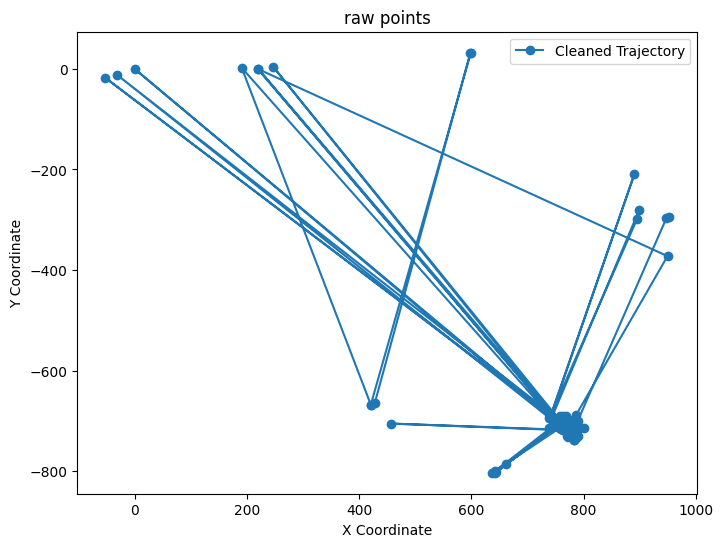

media: 98.94800885118264 std: 256.58659070438455


C:\Users\miche\AppData\Local\Temp\ipykernel_13532\3502962490.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = np.sqrt(dx**2 + dy**2)


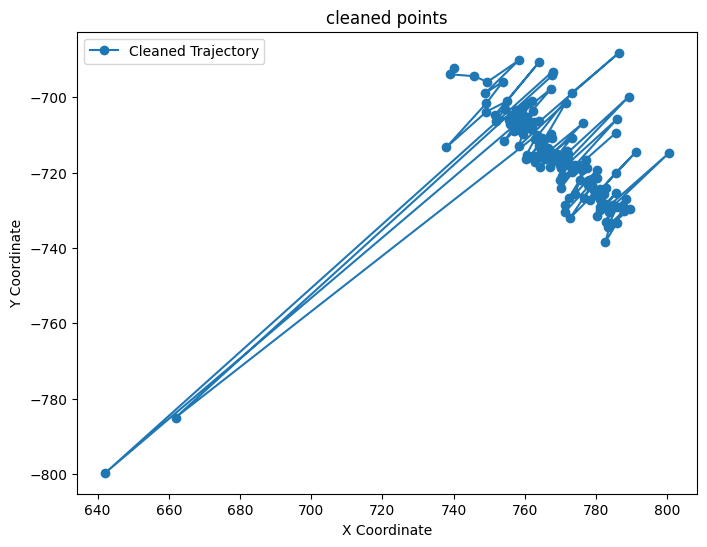

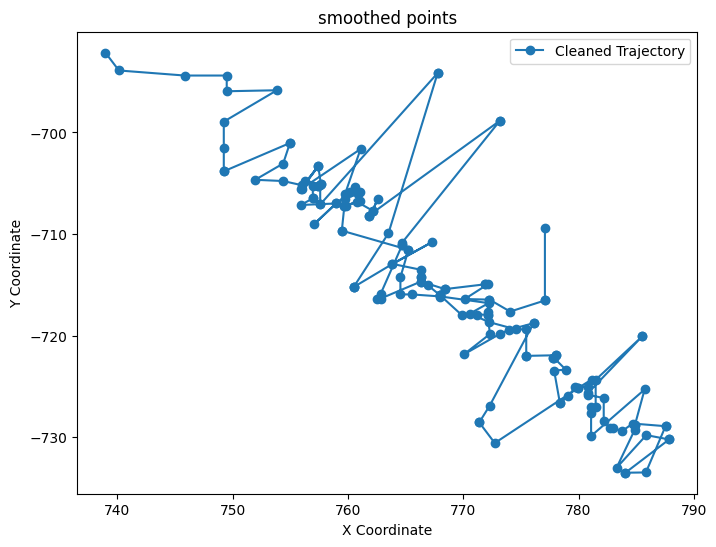

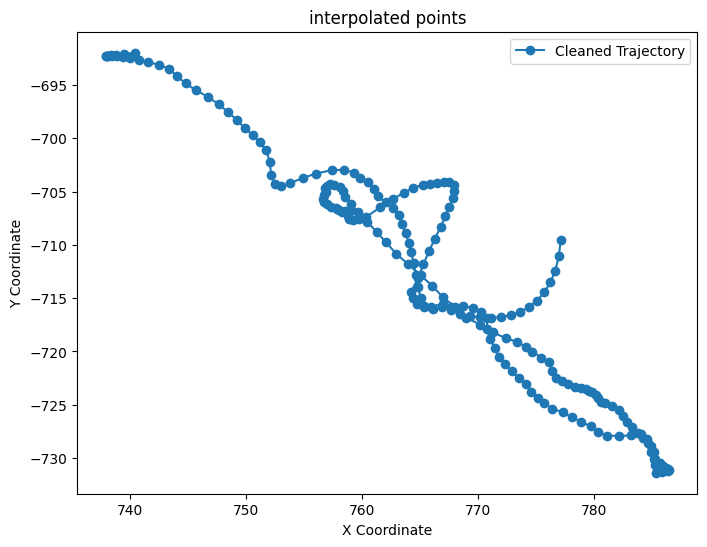

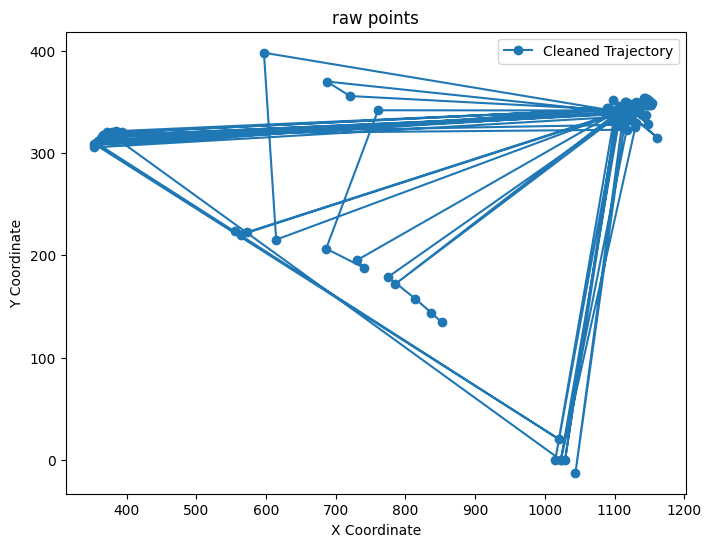

media: 121.64404301468834 std: 238.34899198089488


C:\Users\miche\AppData\Local\Temp\ipykernel_13532\3502962490.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['distance'] = np.sqrt(dx**2 + dy**2)


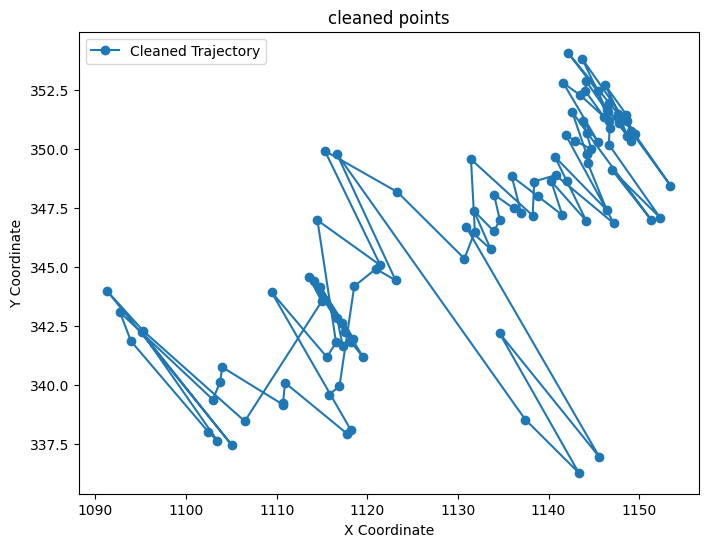

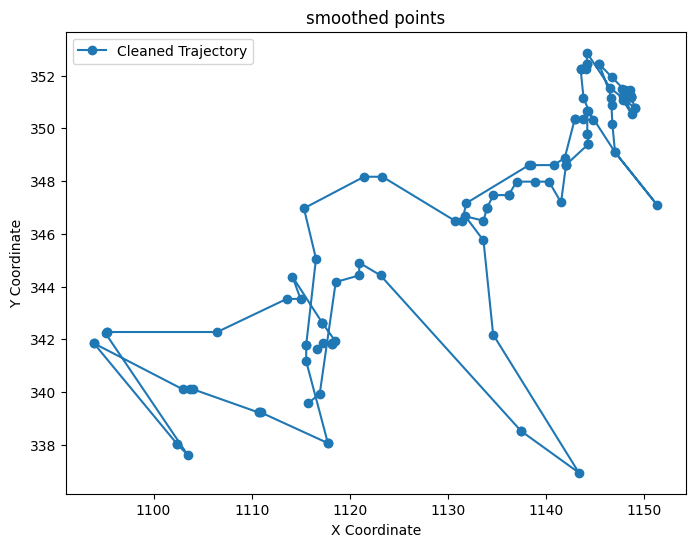

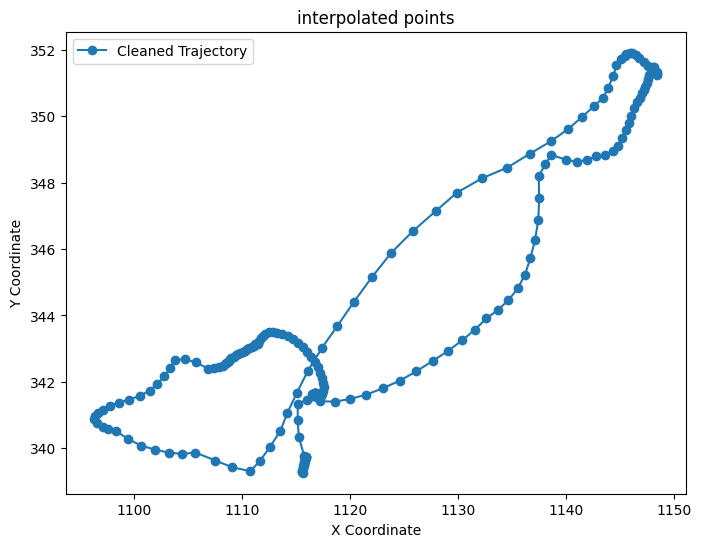

len left: 201 len right: 201 len lines: 201
Processed lines: [[[-1013.87602281, 873.2539209, 985.87602281, 904.7460791], [48, 1432, 1432, -48], [1454, 776, 776, -1454]], [[-1013.87602281, 873.2539209, 985.87602281, 904.7460791], [47, 1431, 1431, -47], [1455, 776, 776, -1455]], [[-1013.87574348, 872.23619323, 985.87574348, 903.76380677], [46, 1430, 1430, -46], [1455, 776, 776, -1455]], [[-1013.87574348, 872.23619323, 985.87574348, 903.76380677], [46, 1430, 1430, -46], [1455, 776, 776, -1455]], [[-1013.87574348, 872.23619323, 985.87574348, 903.76380677], [45, 1430, 1430, -45], [1455, 776, 776, -1455]], [[-1013.87574348, 872.23619323, 985.87574348, 903.76380677], [45, 1430, 1430, -45], [1455, 776, 776, -1455]], [[-1013.87574348, 872.23619323, 985.87574348, 903.76380677], [45, 1430, 1430, -45], [1455, 776, 776, -1455]], [[-1013.87574348, 872.23619323, 985.87574348, 903.76380677], [45, 1430, 1430, -45], [1455, 776, 776, -1455]], [[-1013.87574348, 872.23619323, 985.87574348, 903.76380677], [

C:\Users\miche\AppData\Local\Temp\ipykernel_13532\1156975167.py:9: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  processed_lines.append([lines.iloc[i][0], left_lines_processed[i], right_lines_processed[i]])


Adjusted video saved to C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\data\recording_2\Lines_video_processed.mp4


In [608]:
# Reset the video to the beginning
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Define the codec and create a VideoWriter object to save the modified frames
output_path = project_root / "data" / f"recording_{video_number}"  / "Lines_video_processed.mp4"
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' codec for MP4 format
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(str(output_path), fourcc, fps, (frame_width, frame_height))

# Process the lines
processed_lines = process_lines(lines)
print('Processed lines:', processed_lines)

# initializing df
output_df = pd.DataFrame(columns=['frame_number', 'horizontal', 'left', 'right'])

# Loop through each frame in the video
frame_index = 0
while frame_index < len(lines):
    ret, video_frame = cap.read()
    if not ret:
        print("End of video or failed to read the frame at iteration", frame_index)
        break
    # print(f"Processing frame {frame_index}")

    # draw the lines on the frame   
    modified_frame = write_lines_on_frame(video_frame, processed_lines[frame_index])

    # add lines to the output df
    output_df.loc[len(output_df)] = [frame_index, processed_lines[frame_index][0], processed_lines[frame_index][1], processed_lines[frame_index][2]]

    # Write the modified frame to the output video
    out.write(modified_frame)

    # Increment the frame index
    frame_index += 1

# Release the video capture and writer objects
# cap.release()
out.release()

print(f"Adjusted video saved to {output_path}")

Save lines

In [609]:
# Define the output path for the lines CSV file
output_lines_path = project_root / "data" / "auxiliary_data" / "lane_lines" / f"definitive_lines_{video_number}.csv"

# Convert lines_array to a DataFrame
lines_df = pd.DataFrame(output_df)

# Save the DataFrame to a CSV file
output_df.to_csv(output_lines_path, index=False)

print(f"Lines array saved to {output_lines_path}")

Lines array saved to C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\data\auxiliary_data\lane_lines\definitive_lines_2.csv


Read from created df

In [610]:
# string_lines_path  = project_root / "data" / "auxiliary_data" / "lane_lines" / "definitive_lines_3.csv"

# output_lines = pd.read_csv(string_lines_path)

# print(type(output_lines['horizontal'][0]))